In [1]:
import os
import copy
import random
import warnings
import unittest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler, random_split

from PIL import Image
from torchvision import datasets
from torchvision.datasets.mnist import read_image_file, read_label_file

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
path = "/home/kalisto/Documents/spbu_dl_2025/data/YearPredictionMSD.txt"
data = pd.read_csv(path, header=None)

y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)
X = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32)

X_train, y_train = X[:14000], y[:14000]
X_test, y_test = X[509345:], y[509345:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(X_train.shape, y_train.shape, X_test.shape)

torch.Size([14000, 90]) torch.Size([14000, 1]) torch.Size([6000, 90])


In [3]:
class NAdam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, schedule_decay=0.004, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, schedule_decay=schedule_decay, weight_decay=weight_decay)
        super(NAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('NAdam does not support sparse gradients')
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['m_schedule'] = 1.0
                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']
                state['step'] += 1
                t = state['step']
                m_schedule = state['m_schedule']
                m_schedule_new = m_schedule * beta1
                m_schedule_next = m_schedule_new * (1 - 0.5 * (0.96 ** (t * group['schedule_decay'])))
                m_schedule_next_next = m_schedule_next * (1 - 0.5 * (0.96 ** ((t+1) * group['schedule_decay'])))
                state['m_schedule'] = m_schedule_next
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                m_t = beta1 * m + (1 - beta1) * grad
                v_t = beta2 * v + (1 - beta2) * grad * grad
                m_hat = m_t / (1 - m_schedule_next_next)
                grad_term = (beta1 * m_hat + (1 - beta1) * grad / (1 - m_schedule_next_next)) / (torch.sqrt(v_t / (1 - beta2 ** t)) + group['eps'])
                p.data.add_(grad_term, alpha=-group['lr'])
                state['m'], state['v'] = m_t, v_t
        return loss

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.numpy())
X_test_scaled = scaler.transform(X_test.numpy())

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = y_train.clone().detach()
y_test_tensor = y_test.clone().detach()

if y_train_tensor.dtype != torch.float32:
    y_train_tensor = y_train_tensor.float()
if y_test_tensor.dtype != torch.float32:
    y_test_tensor = y_test_tensor.float()
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if y_test_tensor.dim() == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)
    
X_train_scaled = X_train_scaled.to(device)
X_test_scaled = X_test_scaled.to(device)

y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 512),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128)
        )
    def forward(self, x):
        return self.network(x)



In [6]:
model = NeuralNet(X_train.shape[1])
model = model.to(device)
criterion = nn.MSELoss()
optimizer = NAdam(model.parameters(), lr=0.0025)

dataset = TensorDataset(X_train_scaled, y_train_tensor)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

y_train_np = y_train_tensor.cpu().numpy().ravel()
unique, counts = np.unique(y_train_np, return_counts=True)
use_sampler = False
sampler = None
if unique.shape[0] <= 2 and np.issubdtype(y_train_np.dtype, np.integer) or unique.shape[0] <= 10:
    sample_counts = {}
    for u, c in zip(unique, counts):
        sample_counts[u] = c
    weights = np.array([1.0 / sample_counts[float(y)] for y in y_train_np], dtype=np.float32)
    weights_tensor = torch.from_numpy(weights)
    indices = train_dataset.indices if hasattr(train_dataset, 'indices') else list(range(train_size))
    weights_for_train = weights_tensor[indices]
    sampler = WeightedRandomSampler(weights_for_train, num_samples=len(weights_for_train), replacement=True)
    use_sampler = True

batch_size = 512

if use_sampler:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.best_state = None
    def step(self, loss, model):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

Epoch 1/200, Loss: 147930.1891
Epoch 2/200, Loss: 147475.7695
Epoch 3/200, Loss: 146046.1569
Epoch 4/200, Loss: 143405.9604
Epoch 5/200, Loss: 139524.7896
Epoch 6/200, Loss: 134461.9334
Epoch 7/200, Loss: 128323.7283
Epoch 8/200, Loss: 121245.4306
Epoch 9/200, Loss: 113382.7677
Epoch 10/200, Loss: 104906.3437
Epoch 11/200, Loss: 95996.3148
Epoch 12/200, Loss: 86836.1893
Epoch 13/200, Loss: 77608.7563
Epoch 14/200, Loss: 68490.3624
Epoch 15/200, Loss: 59644.7490
Epoch 16/200, Loss: 51220.0916
Epoch 17/200, Loss: 43341.6991
Epoch 18/200, Loss: 36111.0112
Epoch 19/200, Loss: 29600.3540
Epoch 20/200, Loss: 23853.3129
Epoch 21/200, Loss: 18882.6894
Epoch 22/200, Loss: 14674.3738
Epoch 23/200, Loss: 11188.8807
Epoch 24/200, Loss: 8366.3211
Epoch 25/200, Loss: 6133.0452
Epoch 26/200, Loss: 4407.4935
Epoch 27/200, Loss: 3104.7473
Epoch 28/200, Loss: 2144.6781
Epoch 29/200, Loss: 1453.3202
Epoch 30/200, Loss: 966.8432
Epoch 31/200, Loss: 631.8242
Epoch 32/200, Loss: 406.2354
Epoch 33/200, Loss:

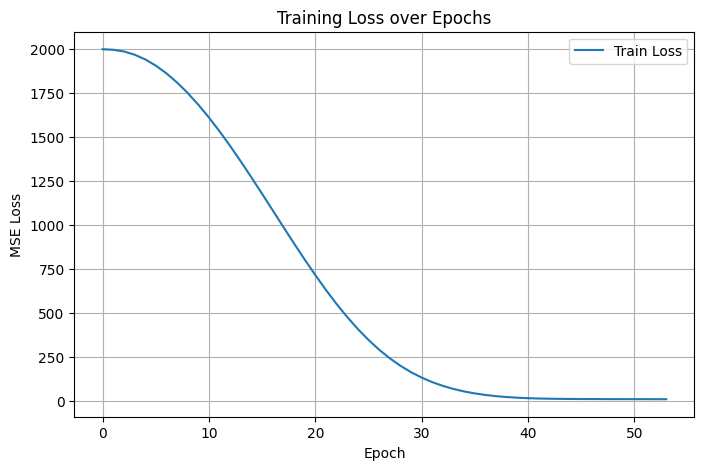

In [8]:
early_stopper = EarlyStopping(patience=6, min_delta=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 200
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss = epoch_loss / train_size
    train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for vX, vy in val_loader:
            vout = model(vX)
            vloss = criterion(vout, vy)
            val_loss += vloss.item() * vX.size(0)
    val_loss = val_loss / val_size
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/(X_train_scaled.size()[0]//batch_size):.4f}")
    scheduler.step(val_loss)
    if early_stopper.step(val_loss, model):
        break

if early_stopper.best_state is not None:
    model.load_state_dict(early_stopper.best_state)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_scaled)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test MSE: {test_loss.item():.4f}")
    pred_year = torch.round(y_pred)
pred_year = torch.round(y_pred)

plt.figure(figsize=(8,5))
plt.plot(np.sqrt(train_losses), label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Задание 2. Свертки и базовые слои 
Это задание будет являться духовным наследником первого. 
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). 
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. 
Однако все элементы, которые вы будете реализовывать, достаточно просты.

### Задача 1. (2 балла)
#### Реализуйте слой BatchNorm (nn.BatchNorm). 

In [9]:
class BatchNorm1d:
    def __init__(self, features: int, eps=1e-6, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(features)
        self.beta = torch.zeros(features)
        self.running_mean = torch.zeros(features)
        self.running_var = torch.ones(features)
        self.training = True
        
    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            mean = x.mean(0)
            var = x.var(0, unbiased = False) #unbiased=False для вычисления точной дисперсии батча
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else: 
            mean = self.running_mean
            var = self.running_var
        return self.gamma * (x-mean) / torch.sqrt(var+self.eps) + self.beta
    
x_example = torch.randn(4,4)
print(x_example)
print(BatchNorm1d(4).forward(x_example))

tensor([[-1.6534,  0.2298,  0.6725,  0.1712],
        [-1.1118, -1.5695, -1.7545, -0.6035],
        [-0.3637,  0.4391,  1.3198, -0.2982],
        [-0.3960,  0.1393,  2.2738, -0.4120]])
tensor([[-1.4385,  0.5228,  0.0300,  1.6006],
        [-0.4295, -1.7161, -1.6003, -1.1136],
        [ 0.9641,  0.7832,  0.4647, -0.0442],
        [ 0.9039,  0.4101,  1.1056, -0.4427]])


In [10]:
class TestBatchNorm1d(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = BatchNorm1d(8).forward(x)
        self.assertEqual(y.shape, x.shape)
        
    def test_mean_var(self):
        x = torch.randn(16,8)
        y = BatchNorm1d(8).forward(x)
        mean = y.mean(0)
        var = y.var(0, unbiased=False)
        self.assertTrue(torch.allclose(mean, torch.zeros_like(mean), atol=1e-1))
        self.assertTrue(torch.allclose(var, torch.ones_like(var), atol=1e-1))

if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

.

.
----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


### Задача 2. (2 балла)
#### Реализуйте слой Linear (nn.Linear). 

In [11]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = torch.randn(out_features, in_features) * 0.01
        self.bias = torch.zeros(out_features)
        
    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weight.t() + self.bias
    
x_example = torch.randn(8, 4)
print(x_example)
print(Linear(4,1).forward(x_example))

tensor([[ 0.5952,  0.2424,  1.5594, -0.4178],
        [-2.3472,  0.8722, -0.1995,  1.4896],
        [-0.8715, -0.4027,  0.1633, -0.2127],
        [-2.0549,  0.5591,  0.8833, -1.9770],
        [-0.0971, -1.7949, -1.1339,  1.0017],
        [ 1.1377,  0.5724, -0.1555, -0.7074],
        [ 0.3484, -0.8940, -0.4405,  0.1468],
        [ 0.2297,  0.2528, -0.2028, -0.0942]])
tensor([[ 0.0019],
        [ 0.0170],
        [ 0.0028],
        [ 0.0409],
        [-0.0331],
        [ 0.0058],
        [-0.0164],
        [ 0.0028]])


In [12]:
class TestBatchNorm1d(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Linear(8,4).forward(x)
        self.assertEqual(y.shape[0], x.shape[0])
        self.assertEqual(y.shape[1], int(x.shape[1]/2))
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


### Задача 3. (2 балла)
#### Реализуйте слой Dropout(nn.Dropout)

In [13]:
class Dropout:
    def __init__(self, p: int):
        self.p = p
        self.training = True
        
    def forward(self, x: Tensor) -> Tensor:
        if not self.training or self.p == 0:
            return X
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1 - self.p)
    
x_example = torch.randn(8, 4)
print(x_example)
print(Dropout(0.8).forward(x_example))

tensor([[-0.1685,  0.6674, -0.2070,  0.3748],
        [-0.4424,  0.0955, -1.5098,  0.6595],
        [-0.3631, -0.5277,  0.8778,  0.7459],
        [ 1.7004,  1.7919, -1.1440,  0.1967],
        [ 0.1758, -0.8761, -0.9143,  1.1247],
        [ 0.8425,  1.2575,  2.2765,  1.3812],
        [ 0.5034,  0.9704,  1.2766, -0.0466],
        [-1.1755, -1.9743, -1.9998,  0.8386]])
tensor([[-0.0000,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.4774, -0.0000,  0.0000],
        [-1.8154, -0.0000,  0.0000,  0.0000],
        [ 8.5019,  0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000, -4.5714,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  0.0000]])


In [14]:
class TestDropout(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Dropout(0.8).forward(x)
        self.assertEqual(y.shape, x.shape)
    
    def test_dropout(self):
        x = torch.randn(16, 8)
        p = 0.5
        y = Dropout(p).forward(x)
        total = x.numel()
        num_zeros = (y == 0).sum().item()
        expected = total * p
        self.assertTrue(abs(num_zeros - expected) / total < 0.2)
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


### Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
#### Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

**1. Sigmoid:**

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$


**2. ReLU:**

$$
\text{ReLU}(x) = \max(0, x)
$$

**3. Softmax:**

$$
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$


In [15]:
class ReLU:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.maximum(torch.tensor(0.0), x)
    
class Sigmoid:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.sigmoid(x)
        #return 1 / (1 + torch.exp(-x))
    
class Softmax:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.softmax(x, dim=1)
        #x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        #return x_exp / x_exp.sum(dim=1, keepdim=True)
    
x_example = torch.randn(4, 2)
print(x_example)
print(ReLU.forward(x_example))
print(Sigmoid.forward(x_example))
print(Softmax.forward(x_example))

tensor([[-0.1101, -0.0112],
        [-0.0506,  0.4179],
        [ 1.4073,  0.9398],
        [-0.6320, -1.3759]])
tensor([[0.0000, 0.0000],
        [0.0000, 0.4179],
        [1.4073, 0.9398],
        [0.0000, 0.0000]])
tensor([[0.4725, 0.4972],
        [0.4874, 0.6030],
        [0.8033, 0.7191],
        [0.3471, 0.2017]])
tensor([[0.4753, 0.5247],
        [0.3850, 0.6150],
        [0.6148, 0.3852],
        [0.6779, 0.3221]])


In [16]:
class SigmoidNative: #σ(x)=1+e−x1​
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        #return torch.sigmoid(x)
        return 1 / (1 + torch.exp(-x))
    
class SoftmaxNative: #σ(x)=1+e−x1​
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        #return torch.softmax(x, dim=1)
        x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        return x_exp / x_exp.sum(dim=1, keepdim=True)

In [17]:
class TestReLU(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = ReLU.forward(x)
        self.assertEqual(y.shape, x.shape)
    
    def test_positive(self):
        x = torch.randn(16, 8)
        y = ReLU.forward(x)
        self.assertTrue((y >= 0).all())
        
class TestSigmoid(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Sigmoid.forward(x)
        y_native = SigmoidNative.forward(x)
        self.assertEqual(y.shape, x.shape)
        self.assertEqual(y_native.shape, x.shape)
    
    def test_sigmoid(self):
        x = torch.randn(16, 8)
        y = Sigmoid.forward(x)
        y_native = SigmoidNative.forward(x)
        self.assertTrue(torch.allclose(y, y_native, atol=1e-6))

class TestSoftmax(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Softmax.forward(x)
        y_native = SoftmaxNative.forward(x)
        self.assertEqual(y.shape, x.shape)
        self.assertEqual(y_native.shape, x.shape)
    
    def test_softmax(self):
        x = torch.randn(16, 8)
        y = Softmax.forward(x)
        y_native = SoftmaxNative.forward(x)
        self.assertTrue(torch.allclose(y, y_native, atol=1e-6))
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.004s

OK


### Задача 5. {*}. 
#### Вы получите по 1 дополнительному баллу за слой, если реализуете в рамках фреймворка из задания 3 прошлой работы

In [18]:
class Custom_Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weight.t() + self.bias

class Custom_Dropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        if not self.training or self.p == 0:
            return x
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1 - self.p)
    
class Custom_ReLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.maximum(torch.tensor(0.0), x)
    
class Custom_Sigmoid(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x)

class Custom_Softmax(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.softmax(x, dim=1)
        
class Custom_BatchNorm1d(nn.Module):
    def __init__(self, features, eps=1e-6, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.register_buffer('running_mean', torch.zeros(features))
        self.register_buffer('running_var', torch.ones(features))

    def forward(self, x):
        if self.training:
            mean = x.mean(0)
            var = x.var(0, unbiased=False)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var
        return self.gamma * (x - mean) / torch.sqrt(var + self.eps) + self.beta


In [19]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            Custom_Linear(input_dim, 256),
            Custom_Dropout(0.2),
            Custom_ReLU(),
            Custom_BatchNorm1d(256),
            Custom_Linear(256, 128),
            Custom_Dropout(0.2),
            Custom_Sigmoid(),
            Custom_BatchNorm1d(128),
            Custom_Linear(128, 512),
            Custom_Dropout(0.2),
            Custom_Softmax(),
            Custom_BatchNorm1d(512),
            Custom_Linear(512, 128)
        )
    def forward(self, x):
        return self.network(x)

In [20]:
model = NeuralNet(X_train.shape[1])
model = model.to(device)
criterion = nn.MSELoss()
optimizer = NAdam(model.parameters(), lr=0.0025)

dataset = TensorDataset(X_train_scaled, y_train_tensor)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

y_train_np = y_train_tensor.cpu().numpy().ravel()
unique, counts = np.unique(y_train_np, return_counts=True)
use_sampler = False
sampler = None
if unique.shape[0] <= 2 and np.issubdtype(y_train_np.dtype, np.integer) or unique.shape[0] <= 10:
    sample_counts = {}
    for u, c in zip(unique, counts):
        sample_counts[u] = c
    weights = np.array([1.0 / sample_counts[float(y)] for y in y_train_np], dtype=np.float32)
    weights_tensor = torch.from_numpy(weights)
    indices = train_dataset.indices if hasattr(train_dataset, 'indices') else list(range(train_size))
    weights_for_train = weights_tensor[indices]
    sampler = WeightedRandomSampler(weights_for_train, num_samples=len(weights_for_train), replacement=True)
    use_sampler = True

batch_size = 512

if use_sampler:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/200, Loss: 147923.6143
Epoch 2/200, Loss: 147473.5701
Epoch 3/200, Loss: 146047.6008
Epoch 4/200, Loss: 143409.2275
Epoch 5/200, Loss: 139528.3147
Epoch 6/200, Loss: 134465.0062
Epoch 7/200, Loss: 128325.5256
Epoch 8/200, Loss: 121245.5694
Epoch 9/200, Loss: 113381.0910
Epoch 10/200, Loss: 104903.0389
Epoch 11/200, Loss: 95991.1841
Epoch 12/200, Loss: 86829.5244
Epoch 13/200, Loss: 77600.9341
Epoch 14/200, Loss: 68481.1661
Epoch 15/200, Loss: 59634.8809
Epoch 16/200, Loss: 51209.2676
Epoch 17/200, Loss: 43330.9557
Epoch 18/200, Loss: 36099.9445
Epoch 19/200, Loss: 29589.5587
Epoch 20/200, Loss: 23842.8201
Epoch 21/200, Loss: 18872.5931
Epoch 22/200, Loss: 14664.9543
Epoch 23/200, Loss: 11180.0048
Epoch 24/200, Loss: 8358.1002
Epoch 25/200, Loss: 6125.5609
Epoch 26/200, Loss: 4400.5479
Epoch 27/200, Loss: 3098.7217
Epoch 28/200, Loss: 2139.2155
Epoch 29/200, Loss: 1448.5659
Epoch 30/200, Loss: 962.4095
Epoch 31/200, Loss: 627.9155
Epoch 32/200, Loss: 402.5606
Epoch 33/200, Loss:

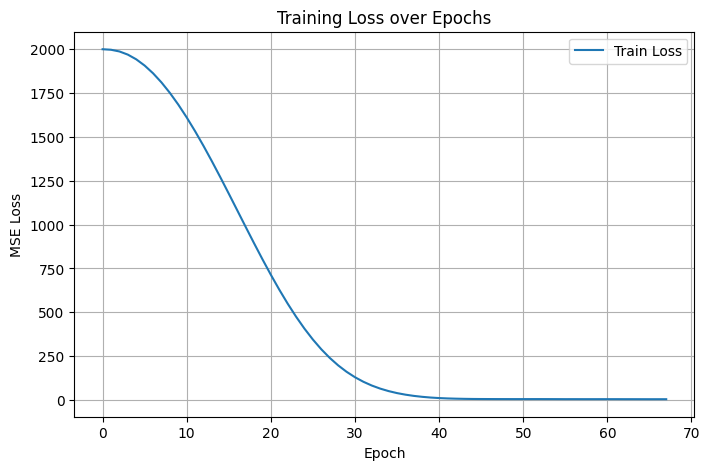

In [21]:
early_stopper = EarlyStopping(patience=6, min_delta=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 200
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss = epoch_loss / train_size
    train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for vX, vy in val_loader:
            vout = model(vX)
            vloss = criterion(vout, vy)
            val_loss += vloss.item() * vX.size(0)
    val_loss = val_loss / val_size
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/(X_train_scaled.size()[0]//batch_size):.4f}")
    scheduler.step(val_loss)
    if early_stopper.step(val_loss, model):
        break

if early_stopper.best_state is not None:
    model.load_state_dict(early_stopper.best_state)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_scaled)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test MSE: {test_loss.item():.4f}")
    pred_year = torch.round(y_pred)
pred_year = torch.round(y_pred)

plt.figure(figsize=(8,5))
plt.plot(np.sqrt(train_losses), label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Задание 2. {*} 3 балла
- Реализуйте медианный фильтр. 
- Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
- сортируются, и выбирается медианное значение из отсортированного массива. 
- Это значение и является выходным для текущего пикселя.
- Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

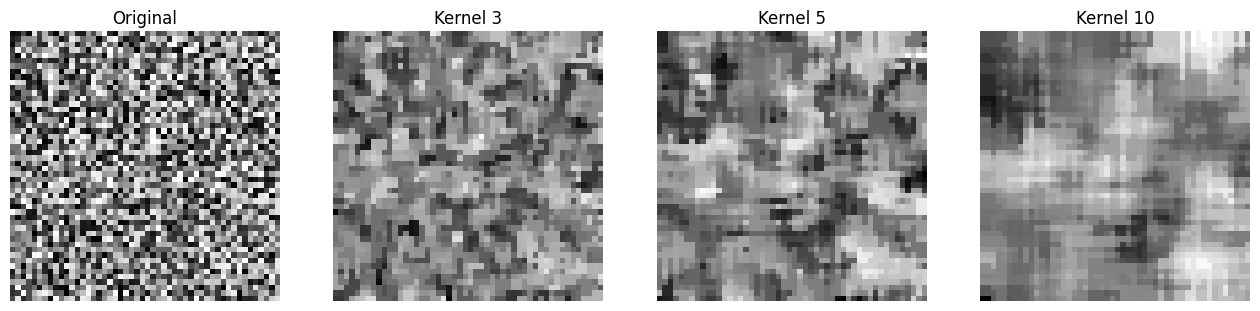

In [22]:
def reflect_pad(img: Tensor, pad: int) -> Tensor:
    H, W = img.shape
    padded = torch.empty((H + 2*pad, W + 2*pad), dtype=img.dtype)
    padded[pad:pad+H, pad:pad+W] = img
    # Верх
    for i in range(pad):
        padded[i, pad:pad+W] = img[pad-i, :]
    # Низ
    for i in range(pad):
        padded[H+pad+i, pad:pad+W] = img[H-2-i, :]
    # Лево и право
    for i in range(H + 2*pad):
        for j in range(pad):
            padded[i, j] = padded[i, 2*pad-j]
            padded[i, W+pad+j] = padded[i, W+pad-2-j]
            
    return padded

def median_filter(img: Tensor, kernel_size: int) -> Tensor:
    pad = kernel_size // 2
    img_padded = reflect_pad(img, pad)
    H, W = img.shape
    filtered = torch.empty_like(img, dtype=torch.float32)
    for i in range(H):
        for j in range(W):
            window = img_padded[i:i+kernel_size, j:j+kernel_size]
            filtered[i, j] = window.flatten().median()
    return filtered
img = torch.randint(0, 256, (50, 50), dtype=torch.uint8)

filtered_3 = median_filter(img, 3)
filtered_5 = median_filter(img, 5)
filtered_10 = median_filter(img, 10)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(filtered_3, cmap='gray')
axes[1].set_title("Kernel 3")
axes[2].imshow(filtered_5, cmap='gray')
axes[2].set_title("Kernel 5")
axes[3].imshow(filtered_10, cmap='gray')
axes[3].set_title("Kernel 10")
for ax in axes:
    ax.axis('off')
plt.show()


### Задание 3. 6 баллов
#### Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

In [43]:
class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img):
        raise NotImplementedError

class RandomCrop(BaseTransform):
    def __init__(self, p: float, size: tuple):
        super().__init__(p)
        self.size = size

    def apply(self, img):
        width, height = img.size
        crop_width, crop_height = self.size
        if crop_width > width or crop_height > height:
            return img
        left = random.randint(0, width - crop_width)
        top = random.randint(0, height - crop_height)
        return img.crop((left, top, left + crop_width, top + crop_height))

class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees: int):
        super().__init__(p)
        self.degrees = degrees

    def apply(self, img):
        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle)

class RandomZoom(BaseTransform):
    def __init__(self, p: float, zoom_range: tuple):
        super().__init__(p)
        self.zoom_range = zoom_range

    def apply(self, img):
        width, height = img.size
        zoom = random.uniform(*self.zoom_range)
        new_width = int(width * zoom)
        new_height = int(height * zoom)
        img = img.resize((new_width, new_height), Image.BILINEAR)
        left = max(0, (new_width - width) // 2)
        top = max(0, (new_height - height) // 2)
        return img.crop((left, top, left + width, top + height))

class ToTensor:
    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        if arr.ndim == 2:
            arr = arr[:, :, None]
        arr = arr.transpose((2, 0, 1))
        arr /= 255.0
        return torch.tensor(arr, dtype=torch.float32)

class Compose:
    def __init__(self, transforms_list):
        self.transforms = transforms_list

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

class FixedSize:
    def __init__(self, size):
        self.size = size
    def __call__(self, img):
        return img.resize(self.size, Image.BILINEAR)



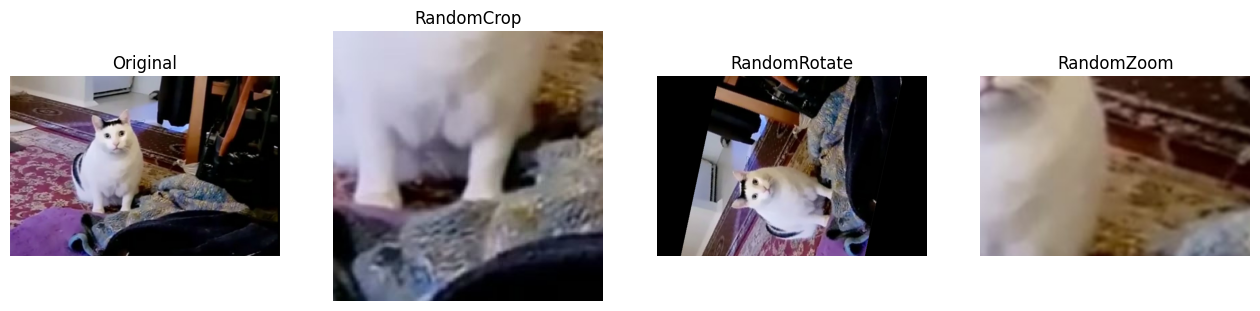

In [44]:
img = Image.open("/home/kalisto/Documents/spbu_dl_2025/images/kot_mjaukaet.jpg")

crop = RandomCrop(p=1.0, size=(200, 200))
rotate = RandomRotate(p=1.0, degrees=90)
zoom = RandomZoom(p=1.0, zoom_range=(0.2, 5))
to_tensor = ToTensor()

img_crop = crop(img)
img_rotate = rotate(img)
img_zoom = zoom(img)
img_tensor = to_tensor(img) 

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(img_crop)
axes[1].set_title("RandomCrop")
axes[2].imshow(img_rotate)
axes[2].set_title("RandomRotate")
axes[3].imshow(img_zoom)
axes[3].set_title("RandomZoom")
for ax in axes:
    ax.axis('off')
plt.show()


In [45]:
class TestTransforms(unittest.TestCase):
    def setUp(self):
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        self.img = Image.fromarray(np.arange(100*100*3, dtype=np.uint8).reshape(100, 100, 3))

    def test_random_crop_reproducibility(self):
        crop = RandomCrop(p=1.0, size=(50, 50))
        random.seed(42)
        result1 = crop(self.img)
        random.seed(42)
        result2 = crop(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_crop_boundary(self):
        crop_large = RandomCrop(p=1.0, size=(200, 200))
        result = crop_large(self.img)
        self.assertEqual(result.size, self.img.size)

    def test_random_rotate_reproducibility(self):
        rotate = RandomRotate(p=1.0, degrees=45)
        random.seed(42)
        result1 = rotate(self.img)
        random.seed(42)
        result2 = rotate(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_zoom_reproducibility(self):
        zoom = RandomZoom(p=1.0, zoom_range=(0.5, 2.0))
        random.seed(42)
        result1 = zoom(self.img)
        random.seed(42)
        result2 = zoom(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_zoom_boundary(self):
        zoom_fixed = RandomZoom(p=1.0, zoom_range=(1.0, 1.0))
        result = zoom_fixed(self.img)
        self.assertEqual(result.size, self.img.size)

    def test_to_tensor(self):
        to_tensor = ToTensor()
        tensor_result = to_tensor(self.img)
        self.assertIsInstance(tensor_result, torch.Tensor)
        self.assertEqual(tensor_result.shape, (3, 100, 100))
        self.assertTrue(torch.all((tensor_result >= 0) & (tensor_result <= 1)))

    def test_compose_reproducibility(self):
        compose = Compose([
            RandomCrop(p=1.0, size=(50, 50)),
            RandomRotate(p=1.0, degrees=30),
            RandomZoom(p=1.0, zoom_range=(0.5, 1.5))
        ])
        random.seed(42)
        result1 = compose(self.img)
        random.seed(42)
        result2 = compose(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

if __name__ == "__main__":
    unittest.main(argv=[""], exit=False)


................
----------------------------------------------------------------------
Ran 16 tests in 0.009s

OK


### Задание 4. 3 балла
- Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
- **В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
- Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
- Проведите обучение на большом количестве эпох. 
- Опишите, что вы наблюдаете для каждого случая и какая есть разница,
- если применить трансформации.
- Предоставьте графики в matplotlib или tensorboard (+1 балл) в 
- ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

no_aug Epoch 1: Train 0.4601/0.8275, Test 0.3818/0.8564
no_aug Epoch 2: Train 0.3373/0.8740, Test 0.3430/0.8763
no_aug Epoch 3: Train 0.3106/0.8839, Test 0.3387/0.8766
no_aug Epoch 4: Train 0.3027/0.8857, Test 0.3445/0.8802
no_aug Epoch 5: Train 0.2901/0.8903, Test 0.3450/0.8802
no_aug Epoch 6: Train 0.2839/0.8936, Test 0.3528/0.8790
no_aug Epoch 7: Train 0.2789/0.8947, Test 0.3543/0.8762
no_aug Epoch 8: Train 0.2704/0.8984, Test 0.3274/0.8839
no_aug Epoch 9: Train 0.2650/0.8999, Test 0.3530/0.8864
no_aug Epoch 10: Train 0.2630/0.9015, Test 0.3857/0.8680
crop Epoch 1: Train 0.4792/0.8211, Test 0.3808/0.8574
crop Epoch 2: Train 0.3568/0.8671, Test 0.3864/0.8598
crop Epoch 3: Train 0.3355/0.8743, Test 0.3737/0.8621
crop Epoch 4: Train 0.3185/0.8806, Test 0.3873/0.8622
crop Epoch 5: Train 0.3072/0.8855, Test 0.3420/0.8772
crop Epoch 6: Train 0.2966/0.8880, Test 0.3404/0.8783
crop Epoch 7: Train 0.2967/0.8898, Test 0.3461/0.8794
crop Epoch 8: Train 0.2880/0.8932, Test 0.3741/0.8710
crop Ep

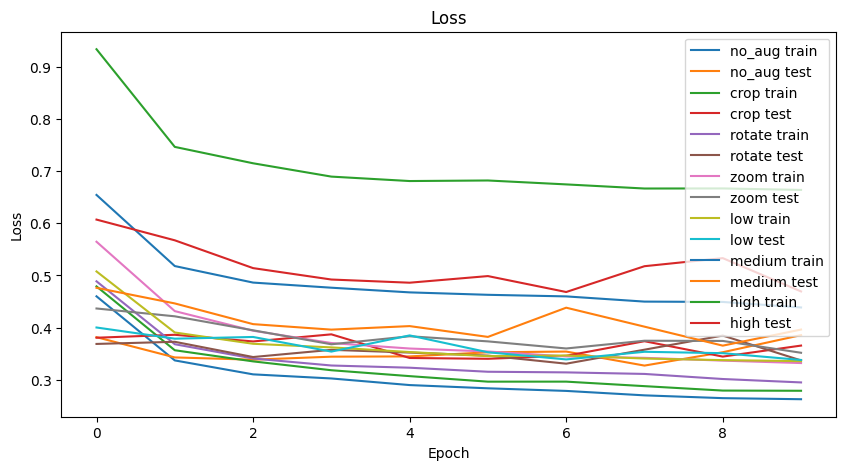

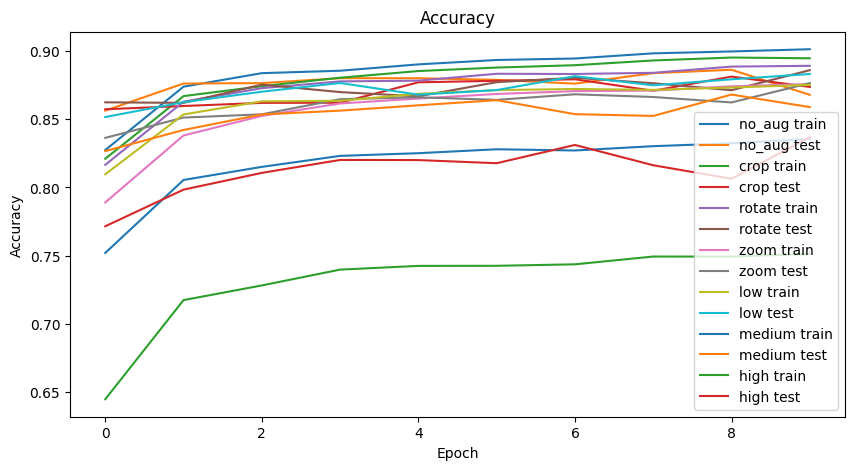

In [ ]:
# Настройки
batch_size = 64
epochs = 10
learning_rate = 0.01

# Трансформации
transform_no_aug = Compose([ToTensor()])

transform_aug_crop = Compose([RandomCrop(0.3, (28,28)), FixedSize((28,28)), ToTensor()])
transform_aug_rotate = Compose([RandomRotate(0.3,15), FixedSize((28,28)), ToTensor()])
transform_aug_zoom = Compose([RandomZoom(0.7,(0.9,1.1)), FixedSize((28,28)), ToTensor()])

transform_aug_low = Compose([RandomCrop(0.3,(28,28)), RandomRotate(0.3,15), RandomZoom(0.3,(0.9,1.1)), FixedSize((28,28)), ToTensor()])
transform_aug_medium = Compose([RandomCrop(0.5,(28,28)), RandomRotate(0.5,30), RandomZoom(0.5,(0.7,1.4)), FixedSize((28,28)), ToTensor()])
transform_aug_high = Compose([RandomCrop(0.7,(28,28)), RandomRotate(0.7,45), RandomZoom(0.7,(0.5,2)), FixedSize((28,28)), ToTensor()])

# Датасеты и загрузчики
train_loaders = {
    "no_aug": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_no_aug), batch_size=batch_size, shuffle=True),
    "crop": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_crop), batch_size=batch_size, shuffle=True),
    "rotate": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_rotate), batch_size=batch_size, shuffle=True),
    "zoom": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_zoom), batch_size=batch_size, shuffle=True),
    "low": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_low), batch_size=batch_size, shuffle=True),
    "medium": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_medium), batch_size=batch_size, shuffle=True),
    "high": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_high), batch_size=batch_size, shuffle=True),
}

test_loader = DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=False, download=True, transform=ToTensor()), batch_size=batch_size, shuffle=False)

# Модель
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Функции обучения и теста
def train_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device | str) -> tuple:
    model.train()
    total_loss, correct, total = 0,0,0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    return total_loss/total, correct/total

def test_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device | str) -> tuple:
    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
    return total_loss/total, correct/total

device = "cuda" if torch.cuda.is_available() else "cpu"

# Обучение
histories = {}
for name, loader in train_loaders.items():
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"{name} Epoch {epoch+1}: Train {train_loss:.4f}/{train_acc:.4f}, Test {test_loss:.4f}/{test_acc:.4f}")
    histories[name] = (train_losses, train_accs, test_losses, test_accs)

# Графики
for metric_name, idx in zip(["Loss","Accuracy"], [0,1]):
    plt.figure(figsize=(10,5))
    for name in histories:
        train_vals = histories[name][idx]
        test_vals = histories[name][idx+2]
        plt.plot(train_vals, label=f"{name} train")
        plt.plot(test_vals, label=f"{name} test")
    plt.title(metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [51]:
device

'cuda'